In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp
import pickle

In [2]:
no_emissions = empty_emissions(1765,2500)

baseline_emissions = pd.read_csv('Best_estimate_emissions_for_UnFaIR.csv',index_col=0)

s = '85'

RCP_extension = pd.DataFrame(data = np.array([pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)[['OtherCO2','FossilCO2']].sum(axis=1).values,pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)['CH4'].values,pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0).index)

RCP_extension = RCP_extension * baseline_emissions.loc[2012] / RCP_extension.loc[2012]

baseline_scenario = pd.concat([baseline_emissions,RCP_extension.loc[2013:]])

In [3]:
baseline_run = UnFaIR(emissions_in=baseline_scenario)

In [4]:
CO2_Pulse_E = baseline_scenario.copy()

## GtC

CO2_Pulse_E.loc[2019,'CO2'] += 1 * 12 / 44

CO2_Pulse = UnFaIR(emissions_in=CO2_Pulse_E)

In [5]:
CH4_Pulse_E = baseline_scenario.copy()

## MtCH4

CH4_Pulse_E.loc[2019,'CH4'] += 1000

CH4_Pulse = UnFaIR(emissions_in=CH4_Pulse_E)

In [6]:
N2O_Pulse_E = baseline_scenario.copy()

## MtN2

N2O_Pulse_E.loc[2019,'N2O'] += 1000 * 28 / 44

N2O_Pulse = UnFaIR(emissions_in=N2O_Pulse_E)

In [7]:
CO2_RF_sum = sp.integrate.simps(CO2_Pulse['RF']['Total'].loc[2019:2119] - baseline_run['RF']['Total'].loc[2019:2119])
CH4_RF_sum = sp.integrate.simps(CH4_Pulse['RF']['Total'].loc[2019:2119] - baseline_run['RF']['Total'].loc[2019:2119])
N2O_RF_sum = sp.integrate.simps(N2O_Pulse['RF']['Total'].loc[2019:2119] - baseline_run['RF']['Total'].loc[2019:2119])

GWP100_CH4 = CH4_RF_sum / CO2_RF_sum
GWP100_N2O = N2O_RF_sum / CO2_RF_sum

print(GWP100_CH4)
print(GWP100_N2O)

26.20348619770768
326.4180854106161


In [8]:
IAMC15 = pd.read_csv('./Conc_fit_data/iamc15_snapshot_1552339163.csv')
IAMC15['ModScen'] = IAMC15['Model']+IAMC15['Scenario']

CH4_Scen = IAMC15.loc[(IAMC15.Variable == "Emissions|CH4")]
CO2_Scen = IAMC15.loc[(IAMC15.Variable == "Emissions|CO2")]
N2O_Scen = IAMC15.loc[(IAMC15.Variable == "Emissions|N2O")]

In [9]:
IAMC15_FORC = pd.read_csv('./Conc_fit_data/iamc15_snapshot_1552340476.csv')
IAMC15_FORC['ModScen'] = IAMC15_FORC['Model'] + IAMC15_FORC['Scenario']

Forc_Tot = IAMC15_FORC.loc[IAMC15_FORC['Variable'] == "Forcing"]
Forc_CO2 = IAMC15_FORC.loc[IAMC15_FORC['Variable'] == "Forcing|CO2"]
Forc_CH4 = IAMC15_FORC.loc[IAMC15_FORC['Variable'] == "Forcing|CH4"]
Forc_N2O = IAMC15_FORC.loc[IAMC15_FORC['Variable'] == "Forcing|N2O"]

In [10]:
common = set.intersection(\
                          set(Forc_Tot['ModScen']),set(Forc_CO2['ModScen']),set(Forc_CH4['ModScen']),set(Forc_N2O['ModScen'])\
                         ,set(CO2_Scen['ModScen']),set(CH4_Scen['ModScen']),set(N2O_Scen['ModScen']))

TOT_FORC_15=Forc_Tot.loc[Forc_Tot['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()
CO2_FORC_15=Forc_CO2.loc[Forc_CO2['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()
CH4_FORC_15=Forc_CH4.loc[Forc_CH4['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()
N2O_FORC_15=Forc_N2O.loc[Forc_N2O['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()
CO2_EMS_15=CO2_Scen.loc[CO2_Scen['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()
CH4_EMS_15=CH4_Scen.loc[CH4_Scen['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()
N2O_EMS_15=N2O_Scen.loc[N2O_Scen['ModScen'].isin(common)].sort_values('ModScen').iloc[:,5:-1].replace(to_replace=0.0,value=np.nan).transpose().set_index(np.arange(2010,2101,5)).reindex(np.arange(2010,2101)).interpolate()

In [11]:
(TOT_FORC_15.values - CO2_FORC_15.values - CH4_FORC_15.values - N2O_FORC_15.values)

s='85'

RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

otherforc = RCP_forc.TOTAL_INCLVOLCANIC_RF.loc[:2009].values - RCP_forc.CO2CH4N2O_RF.loc[:2009].values

s = '85'

RCP_E = pd.DataFrame(data = np.array([pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)[['OtherCO2','FossilCO2']].sum(axis=1).values,pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)['CH4'].values,pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0)['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = pd.read_csv('./RCP_data/RCP'+s+'_EMISSIONS.csv',skiprows=36,index_col=0).index)

BE_E = pd.read_csv('Best_estimate_emissions_for_UnFaIR.csv',index_col=0)

In [12]:
## Test with the scenarios:

Scenario_Temps = pd.DataFrame(index = np.arange(1765,2101))

for s_num in np.arange(TOT_FORC_15.columns.size):

    ## The colname of the results will be the index number of the co2 scenario df
    s_name = CO2_EMS_15.iloc[:,s_num].name

    BE_CO2 = BE_E.loc[:2009,'CO2']
    scenario_co2_ems = CO2_EMS_15.iloc[:,s_num] * 12 / 44 / 1000 
    scenario_co2_ems += np.linspace(BE_E.loc[2010,'CO2'] - scenario_co2_ems.loc[2010],0,2101-2010)
    #RCP_co2_ext = RCP_E.loc[:2009,'CO2'] / RCP_E.loc[2010,'CO2'] * CO2_EMS_15.iloc[:,s_num].loc[2010] * 12 / 44 / 1000

    full_co2_ems = np.concatenate((BE_CO2,scenario_co2_ems))

    BE_CH4 = BE_E.loc[:2009,'CH4']
    scenario_ch4_ems = CH4_EMS_15.iloc[:,s_num]
    scenario_ch4_ems += np.linspace(BE_E.loc[2010,'CH4'] - scenario_ch4_ems.loc[2010],0,2101-2010)
    #RCP_ch4_ext = RCP_E.loc[:2009,'CH4'] / RCP_E.loc[2010,'CH4'] * CH4_EMS_15.iloc[:,s_num].loc[2010]

    full_ch4_ems = np.concatenate((BE_CH4,scenario_ch4_ems))

    BE_N2O = BE_E.loc[:2009,'N2O']
    scenario_n2o_ems = N2O_EMS_15.iloc[:,s_num] / 1000 * 28 / 44
    scenario_n2o_ems += np.linspace(BE_E.loc[2010,'N2O'] - scenario_n2o_ems.loc[2010],0,2101-2010)
    #RCP_n2o_ext = RCP_E.loc[:2009,'N2O'] / RCP_E.loc[2010,'N2O'] * N2O_EMS_15.iloc[:,s_num].loc[2010] / 1000 * 28 / 44
    
    full_n2o_ems = np.concatenate((BE_N2O,scenario_n2o_ems))

    scenario_other_forcing = TOT_FORC_15.iloc[:,s_num].values - CO2_FORC_15.iloc[:,s_num].values - CH4_FORC_15.iloc[:,s_num].values - N2O_FORC_15.iloc[:,s_num].values
    scaling = (RCP_forc['TOTAL_INCLVOLCANIC_RF'] - RCP_forc['CO2CH4N2O_RF']).loc[2010] - scenario_other_forcing[0]
    scenario_other_forcing += np.linspace(scaling,0,2101-2010)
    RCP_other_forc = (RCP_forc['TOTAL_INCLVOLCANIC_RF'] - RCP_forc['CO2CH4N2O_RF']).loc[:2009]
    full_other_forcing = np.concatenate((RCP_other_forc,scenario_other_forcing))

    scenario_emissions = pd.DataFrame(data=np.array([full_co2_ems,full_ch4_ems,full_n2o_ems]).T,index=np.arange(1765,2101),columns=['CO2','CH4','N2O'])

    scenario_result = UnFaIR(emissions_in = scenario_emissions , F_ext = full_other_forcing)
    
    
    
    Scenario_Temps[s_name] = scenario_result['T']['Total'].values

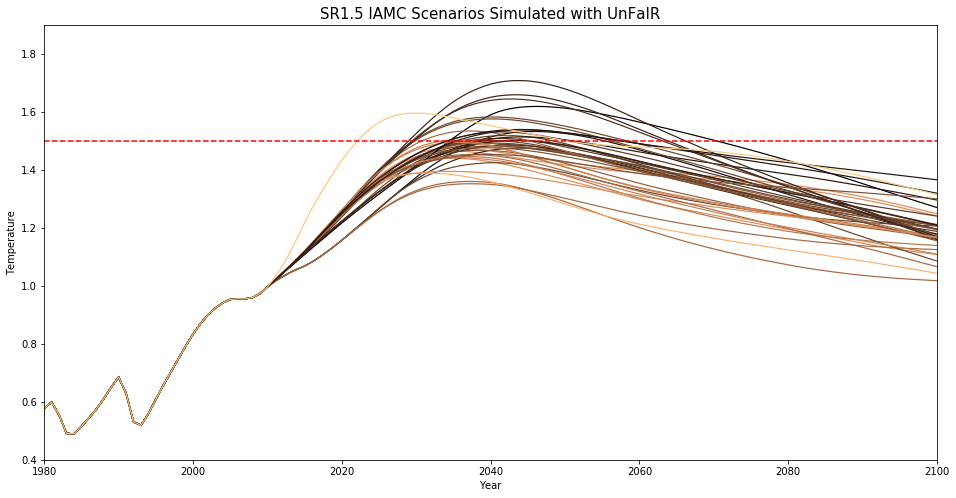

In [13]:
Scenario_Temps -= Scenario_Temps.loc[1850:1900].mean()

Peak_warming = Scenario_Temps.loc[2010:].diff().abs().idxmin()

fig,ax=plt.subplots(figsize=(16,8))
Scenario_Temps.plot(ax=ax,color=matplotlib.cm.copper_r((Peak_warming-Peak_warming.min())/(Peak_warming.max()-Peak_warming.min())),legend=None,linewidth=1.2)
ax.set_xlim(1980,2100)
ax.set_title('SR1.5 IAMC Scenarios Simulated with UnFaIR',fontsize=15)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_ylim(0.4,1.9)
ax.axhline(1.5,color='r',linestyle='--')

In [14]:
## Getting some plumes for concentration

T_response = UnFaIR(BE_E,(RCP_forc['TOTAL_INCLVOLCANIC_RF'] - RCP_forc['CO2CH4N2O_RF']).loc[:2012].values)['T']['Total']

N=1000

CH4_plume = pd.DataFrame(index=BE_E.index)
N2O_plume = pd.DataFrame(index=BE_E.index)
CO2_plume = pd.DataFrame(index=BE_E.index)

for i in np.arange(N):
    
    gas_params_var = default_gas_params()
    
    gas_params_var.loc['r0','CH4'] = gas_params_var.loc['r0','CH4']*np.random.normal(1,0.11)
    gas_params_var.loc['rA','CH4'] = gas_params_var.loc['rA','CH4']*np.random.normal(1,0.15)
    gas_params_var.loc['rT','CH4'] = gas_params_var.loc['rT','CH4']*np.random.normal(1,0.13)
    gas_params_var.loc['r0','N2O'] = gas_params_var.loc['r0','N2O']*np.random.normal(1,0.24)
    gas_params_var.loc['rA','N2O'] = gas_params_var.loc['rA','N2O']*np.random.normal(1,0.16)
    gas_params_var.loc['r0','CO2'] = gas_params_var.loc['r0','CO2']*np.random.normal(1,0.13)
    gas_params_var.loc['rC','CO2'] = gas_params_var.loc['rC','CO2']*np.random.normal(1,0.13)
    gas_params_var.loc['rT','CO2'] = gas_params_var.loc['rT','CO2']*np.random.normal(1,0.13)
    
    model_run = fit_gas_cycles(BE_E,T_response,gas_params_var)
    
    N2O_plume[i] = model_run['N2O'].values
    CH4_plume[i] = model_run['CH4'].values
    CO2_plume[i] = model_run['CO2'].values

Text(0.5, 0.98, 'Concentrations over the historical (1850-2012) Period')

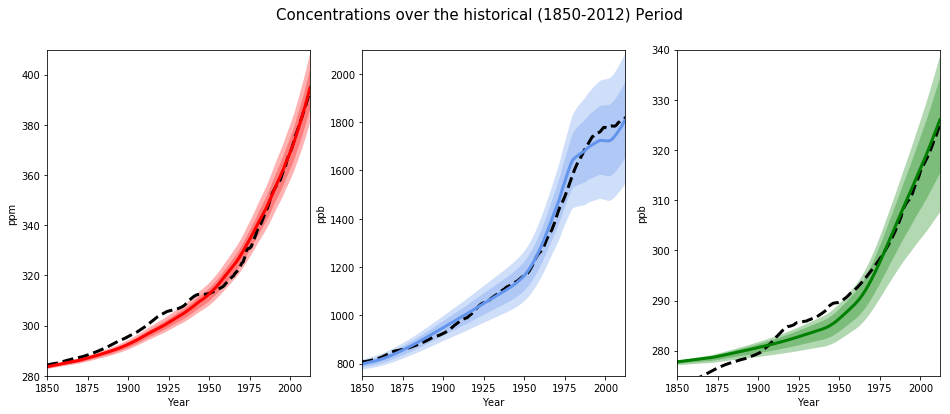

In [15]:
CMIP6_concs = pd.read_csv('./CMIP_input_ems/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

fig,ax=plt.subplots(1,3,figsize=(16,6))

CMIP6_concs['CO2'].loc[1850:].plot(ax=ax[0],color='k',linestyle='--',linewidth=3)

CO2_plume.median(axis=1).plot(ax=ax[0],color='r',linewidth=3)
ax[0].fill_between(CO2_plume.index,np.percentile(CO2_plume,17,axis=1),np.percentile(CO2_plume,83,axis=1),alpha=0.3,color='r',linewidth=0)
ax[0].fill_between(CO2_plume.index,np.percentile(CO2_plume,5,axis=1),np.percentile(CO2_plume,95,axis=1),alpha=0.3,color='r',linewidth=0)

ax[0].set_xlim(1850,2012)
ax[0].set_ylim(280,410)

CMIP6_concs['CH4'].loc[1850:].plot(ax=ax[1],color='k',linestyle='--',linewidth=3)

CH4_plume.median(axis=1).plot(ax=ax[1],color='cornflowerblue',linewidth=3)
ax[1].fill_between(CH4_plume.index,np.percentile(CH4_plume,17,axis=1),np.percentile(CH4_plume,83,axis=1),alpha=0.3,color='cornflowerblue',linewidth=0)
ax[1].fill_between(CH4_plume.index,np.percentile(CH4_plume,5,axis=1),np.percentile(CH4_plume,95,axis=1),alpha=0.3,color='cornflowerblue',linewidth=0)

ax[1].set_xlim(1850,2012)
ax[1].set_ylim(750,2100)

#CH4_plume.plot(ax=ax[0],color='b',linewidth=0.1,legend=None,zorder=0)

CMIP6_concs['N2O'].loc[1850:].plot(ax=ax[2],color='k',linestyle='--',linewidth=3)

N2O_plume.median(axis=1).plot(ax=ax[2],color='green',linewidth=3)
ax[2].fill_between(N2O_plume.index,np.percentile(N2O_plume,17,axis=1),np.percentile(N2O_plume,83,axis=1),alpha=0.3,color='green',linewidth=0)
ax[2].fill_between(N2O_plume.index,np.percentile(N2O_plume,5,axis=1),np.percentile(N2O_plume,95,axis=1),alpha=0.3,color='green',linewidth=0)

ax[2].set_xlim(1850,2012)
ax[2].set_ylim(275,340)

ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[2].set_xlabel('Year')
ax[0].set_ylabel('ppm')
ax[1].set_ylabel('ppb')
ax[2].set_ylabel('ppb')
plt.suptitle('Concentrations over the historical (1850-2012) Period',fontsize=15)
